In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, IncrementalPCA
from sklearn.cross_decomposition import PLSRegression
from data_parser import parse_json_data, process_path, parse_label

np.random.seed(42)

pes_features = []
wool_features = []
cotton_features = []

all_features = []
all_labels = []
data_path = "../data/"
files = process_path(data_path)

for file_path in files:
    file_label = parse_label(file_path)
    file_features = parse_json_data(file_path)
    if (file_label == "pes"):
        pes_features.append(file_features)
    elif (file_label == "villa"):
        wool_features.append(file_features)
    elif (file_label == "puuvilla"):
        cotton_features.append(file_features)
        
    all_labels.append(file_label)

# Define features and labels according to dataset
pes = pd.DataFrame(pes_features[:200])
wool = pd.DataFrame(wool_features[:200])
cotton = pd.DataFrame(cotton_features[:200])
labels = pd.DataFrame(all_labels, columns=['fabric_type'])

# Combine features
all_features = pd.concat([pes, wool, cotton], axis=0).reset_index(drop=True)

# One-hot encode labels dynamically
fabric_types = ["pes", "villa", "puuvilla"]
label_array = np.array([[1, 0, 0]] * 200 + [[0, 1, 0]] * 200 + [[0, 0, 1]] * 200)
labels = pd.DataFrame(label_array, columns=fabric_types)

# [0,0,0,0,1,0,0,0,...] eye for labels (optional for the solution above)
num_samples = len(all_features)
one_hot_labels = np.eye(num_samples)
labels_df = pd.DataFrame(one_hot_labels)

# Print shapes to verify
print("Features Shape:", all_features.shape)
print("Labels Shape:", labels.shape)

Found 1400 .json files.
Features Shape: (600, 512)
Labels Shape: (600, 3)


In [5]:
# Common k elements for svd
k = 6

(200, 512)


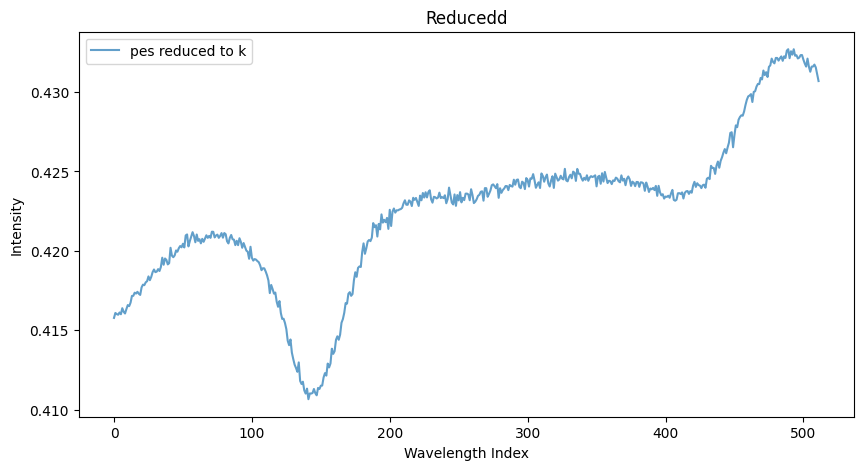

Shape of Up: (200, 200)
Shape of Sp: (200,)
Shape of Vtp: (200, 512)
First row of Vtp: [-0.04565743 -0.04565112 -0.04564543 -0.04561436 -0.04567866 -0.04567675
 -0.04567048 -0.04561472 -0.04564558 -0.04565881 -0.04564433 -0.04568113
 -0.04567989 -0.04565088 -0.0456822  -0.0457114  -0.04563864 -0.04569926
 -0.04566501 -0.04567409 -0.0456415  -0.04569993 -0.0456713  -0.04566634
 -0.0456561  -0.0456709  -0.0456528  -0.04567763 -0.04567436 -0.04565181
 -0.0456344  -0.04564504 -0.0456482  -0.04564567 -0.04565694 -0.04564928
 -0.04563638 -0.04566463 -0.04563858 -0.04561255 -0.0456213  -0.0456891
 -0.04559716 -0.04558206 -0.04562082 -0.04561273 -0.04555022 -0.04556672
 -0.04563576 -0.04560182 -0.04557233 -0.04557977 -0.04560706 -0.04556704
 -0.04552997 -0.04557895 -0.04556887 -0.04556489 -0.04555273 -0.04550242
 -0.04555324 -0.04551153 -0.04546662 -0.04545594 -0.04548547 -0.0454411
 -0.04546184 -0.04542852 -0.04537655 -0.04537273 -0.04539812 -0.04538336
 -0.04539723 -0.0453323  -0.0453373  -0

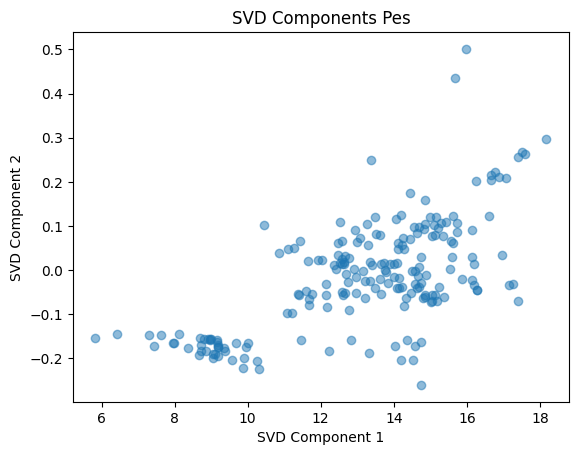

In [15]:
#Pes
print(pes.shape)
Up, Sp, Vtp = np.linalg.svd(pes, full_matrices=False)
pes_reduced = Up[:, :k] @ np.diag(Sp[:k]) @ Vtp[:k, :]
plt.figure(figsize=(10,5))
plt.plot(pes_reduced[0], label=f"pes reduced to k", alpha=0.7)
plt.xlabel("Wavelength Index")
plt.ylabel("Intensity")
plt.title("Reducedd")
plt.legend()
plt.show()

# Inspect the shapes of the resulting components
print("Shape of Up:", Up.shape)
print("Shape of Sp:", Sp.shape)
print("Shape of Vtp:", Vtp.shape)
print("First row of Vtp:", Vtp[0])
print("First row of UP:", Up[0])

print("Shape of pes_reduced:", pes_reduced.shape)

svd_pes = TruncatedSVD(n_components=k)
pes_features = svd_pes.fit_transform(pes)
#print(svd_pes.explained_variance_ratio_)
print(svd_pes.explained_variance_ratio_.sum())
#print(svd.singular_values_)
pes_combined = pd.concat([pes, pd.DataFrame(pes_reduced)], axis=1)

print("Original Shape:", pes.shape)
print("Reduced Feature Shape:", pes_features.shape)

plt.scatter(pes_features[:, 0], pes_features[:, 1], alpha=0.5)
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("SVD Components Pes")
plt.show()

(200, 512)
(200, 512)


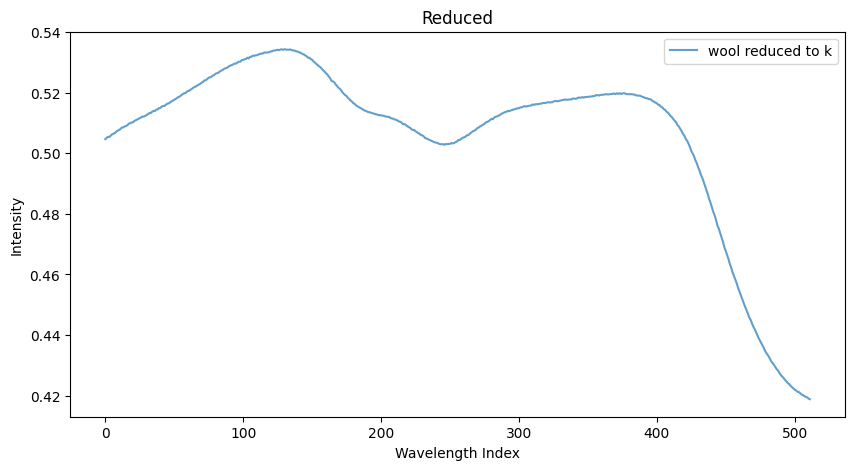

0.9999041709386409
Original Shape: (200, 512)
Reduced Feature Shape: (200, 6)


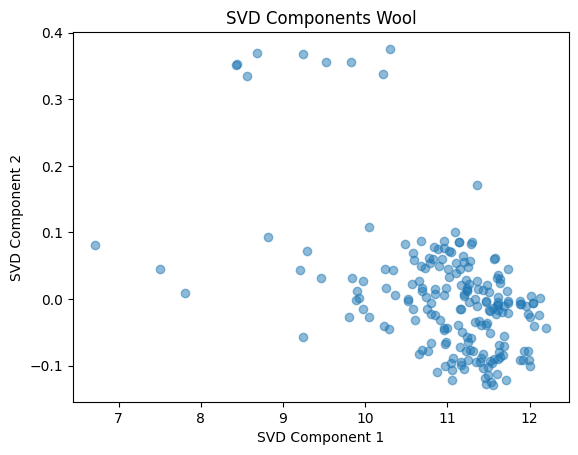

In [13]:
#wool
print(wool.shape)
Uw, Sw, Vtw = np.linalg.svd(wool, full_matrices=False)
wool_reduced = Uw[:, :k] @ np.diag(Sw[:k]) @ Vtw[:k, :]
print(wool_reduced.shape)
plt.figure(figsize=(10,5))
plt.plot(wool_reduced[0], label=f"wool reduced to k", alpha=0.7)
plt.xlabel("Wavelength Index")
plt.ylabel("Intensity")
plt.title("Reduced")
plt.legend()
plt.show()

svd_wool = TruncatedSVD(n_components=k)
wool_features = svd_wool.fit_transform(wool)
#print(svd_wool.explained_variance_ratio_)
print(svd_wool.explained_variance_ratio_.sum())
#print(svd.singular_values_)
wool_combined = pd.concat([wool, pd.DataFrame(wool_reduced)], axis=1)

print("Original Shape:", wool.shape)
print("Reduced Feature Shape:", wool_features.shape)

plt.scatter(wool_features[:, 0], wool_features[:, 1], alpha=0.5)
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("SVD Components Wool")
plt.show()

(200, 512)
(200, 512)


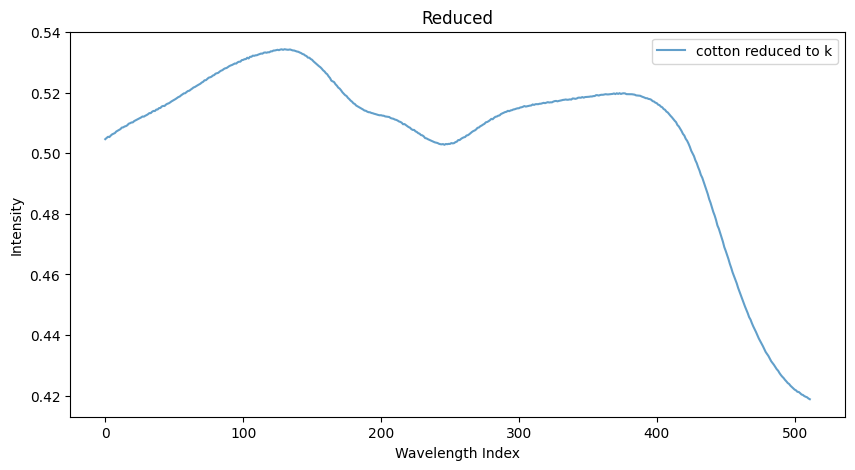

0.9999731838882611
Original Shape: (200, 512)
Reduced Feature Shape: (200, 6)


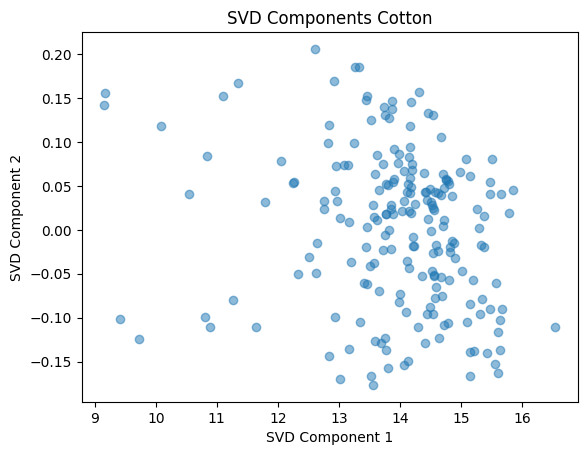

In [8]:
#cotton
print(cotton.shape)
Uc, Sc, Vtc = np.linalg.svd(wool, full_matrices=False)
cotton_reduced = Uc[:, :k] @ np.diag(Sc[:k]) @ Vtc[:k, :]
print(cotton_reduced.shape)
plt.figure(figsize=(10,5))
plt.plot(cotton_reduced[0], label=f"cotton reduced to k", alpha=0.7)
plt.xlabel("Wavelength Index")
plt.ylabel("Intensity")
plt.title("Reduced")
plt.legend()
plt.show()

svd_cotton = TruncatedSVD(n_components=k)
cotton_features = svd_cotton.fit_transform(cotton)
#print(svd_cotton.explained_variance_ratio_)
print(svd_cotton.explained_variance_ratio_.sum())
#print(svd.singular_values_)
cotton_combined = pd.concat([cotton, pd.DataFrame(cotton_reduced)], axis=1)

print("Original Shape:", cotton.shape)
print("Reduced Feature Shape:", cotton_features.shape)

plt.scatter(cotton_features[:, 0], cotton_features[:, 1], alpha=0.5)
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("SVD Components Cotton")
plt.show()

Features Shape (Combined): (600, 1024)
Labels Shape: (600, 3)


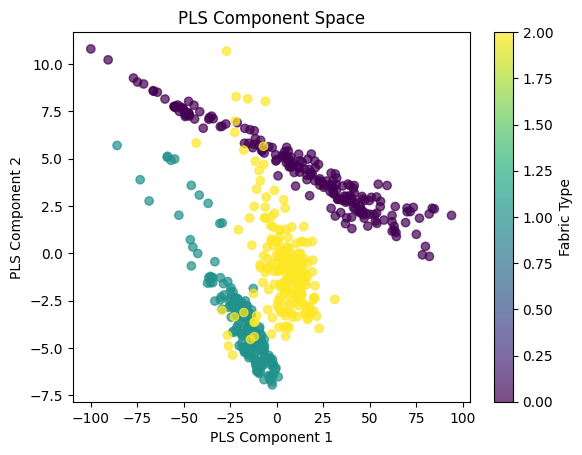

In [9]:
all_combined_features = pd.concat([pes_combined, wool_combined, cotton_combined], axis=0).reset_index(drop=True)
# Print shapes to verify
print("Features Shape (Combined):", all_combined_features.shape)
print("Labels Shape:", labels.shape)


n = 6
plsr = PLSRegression(n_components=6)
x_pls = plsr.fit_transform(all_combined_features, labels_df)

plt.scatter(plsr.x_scores_[:, 0], plsr.x_scores_[:, 2], c=np.argmax(labels.values, axis=1), cmap='viridis', alpha=0.7)
plt.xlabel("PLS Component 1")
plt.ylabel("PLS Component 2")
plt.title("PLS Component Space")
plt.colorbar(label="Fabric Type")
plt.show()

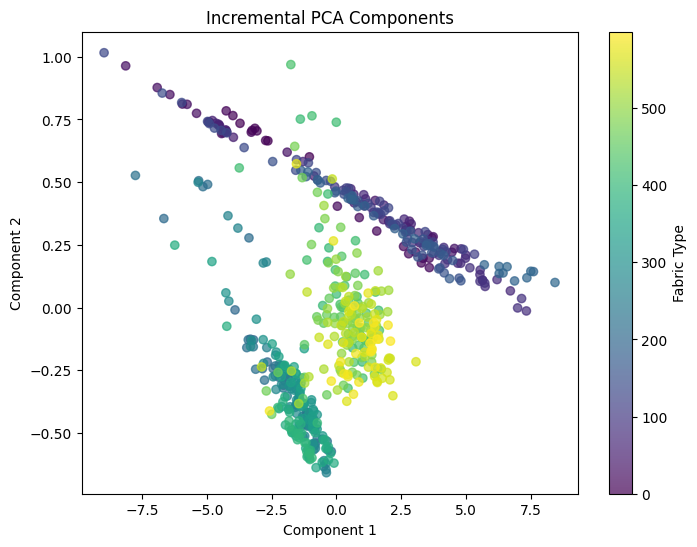

In [10]:
n = 450

ipca = IncrementalPCA(n_components=n, batch_size=1024)
X_ipca = ipca.fit_transform(all_combined_features)

# Plot the first two components
plt.figure(figsize=(8, 6))
plt.scatter(X_ipca[:, 0], X_ipca[:, 2], alpha=0.7, c=np.argmax(labels_df.values, axis=1), cmap='viridis')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Incremental PCA Components")
plt.colorbar(label="Fabric Type")
plt.show()